Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


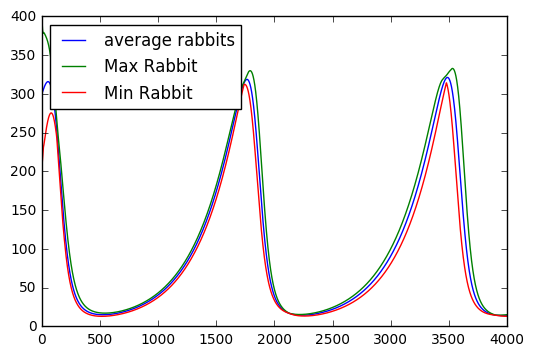

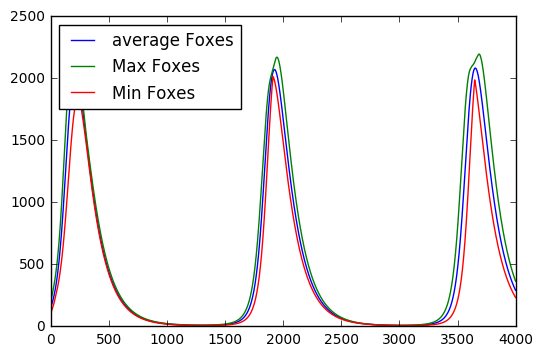

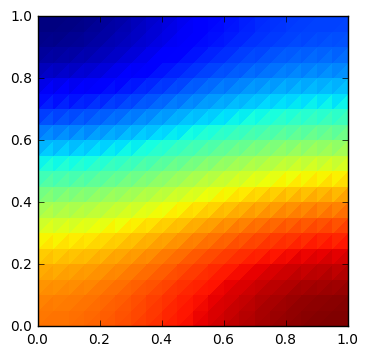

In [2]:
"""This is the solutoion of Diffusive Rabit and Foxes solved
the finite element method using Fenics Project pacake. Warning, the 
installation of Fenics package is not trivial. !!"""

# Copyright (C) 2009 Garth N. Wells
#
# This file is part of DOLFIN.
#
# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.


import random
import copy
import numpy
from dolfin import *
from matplotlib import pyplot as plt
%matplotlib inline

# Class representing the intial conditions
class InitialConditions(Expression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(mpi_comm_world()))
    def eval(self, values, x):
        values[0] =  200+ 200*(random.random()) #+ 400  #400
        values[1] =  100+ 100*(random.random()) #+ 200
    def value_shape(self):
        return (2,)

# Class for interfacing with the Newton solver
class FoxesandRabbitsEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)

# Model parameters
D1  = 0.0001  # Diffusion1
D2  = 0.0001  # Diffusion1
dt     = 0.2  # time step
K1=0.015
K2=0.00004
K3=0.0004
K4=0.04


# Create mesh and build function space
mesh = UnitSquareMesh(20, 20)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = FunctionSpace(mesh, P1*P1)

# Define trial and test functions
du    = TrialFunction(ME)
q, v  = TestFunctions(ME)

# Define functions
u   = Function(ME)  # current solution
u0  = Function(ME)  # solution from previous converged step

# Split mixed functions
dR, dF = split(du)
R,  F  = split(u)
R0, F0 = split(u0)

# Create intial conditions and interpolate
u_init = InitialConditions(degree=1)
u.interpolate(u_init)
#u0.interpolate(u_init)


# Weak statement of the equations
L0= (R*q*dx - R0*q*dx + K2*dt*R*F0*q*dx - K1*dt*R*q*dx 
     + D1*dt*dot(grad(R),grad(q))*dx    )
L1 =( F*v*dx - F0*v*dx - K3*dt*R0*F*v*dx + K4*dt*F*v*dx
      + D2*dt*dot(grad(F),grad(v))*dx    )
L = L0 + L1


# Compute directional derivative about u in the direction of du (Jacobian)
a = derivative(L, u, du)

# Create nonlinear problem and Newton solver
problem = FoxesandRabbitsEquation(a, L)
solver = NewtonSolver()
solver.parameters["linear_solver"] = "lu"
solver.parameters["convergence_criterion"] = "incremental"
solver.parameters["relative_tolerance"] = 1e-10
solver.parameters['absolute_tolerance'] = 1e-10

# Output file
file1 = File("outputR.pvd")
file2 = File("outputF.pvd")

# Step in time
t = 0.0
T = 4000*dt
Foxes = []
Rabbits = []
maxFox =[]
maxRabbit =[]
minFox =[]
minRabbit = []
n= 0
while (t < T):
    t += dt
    u0.vector()[:] = u.vector()
    u_nodal_values = u.vector()
    u_array = u_nodal_values.array()
    solver.solve(problem, u.vector())
    u_nodal_values = u.vector()
    Rabbit_array = u_nodal_values.array()[0::2]
    Foxes_array = u_nodal_values.array()[1::2]
    Foxes.append(numpy.average(Foxes_array))
    Rabbits.append(numpy.average(Rabbit_array))
    maxFox.append(Foxes_array.max())
    maxRabbit.append(Rabbit_array.max())
    minFox.append(Foxes_array.min())
    minRabbit.append(Rabbit_array.min())
    #if (0 <= n%100 <1.0e-6):
       # file1 << (u.split()[0], t)
       # file2 << (u.split()[1], t)

    n+=1

u_nodal_values = u.vector()
Foxes_array = u_nodal_values.array()[0::2]
Rabbit_array = u_nodal_values.array()[1::2]



plt.plot(Rabbits, label='average rabbits')
plt.plot(maxRabbit, label='Max Rabbit')
plt.plot(minRabbit, label='Min Rabbit')
plt.legend(loc="best")
plt.show()

plt.plot(Foxes, label='average Foxes')
plt.plot(maxFox, label='Max Foxes')
plt.plot(minFox, label='Min Foxes')
plt.legend(loc="best")
plt.show()

plot(u.split()[0])
interactive()

